## Load necessary libraries

In [15]:
import os
import cv2
import json
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Image Processing
## Function to Process UI Image and Detect Components

In [16]:
def process_ui_image(image_path):
    # Load the color image
    image = cv2.imread(image_path)
    # Check if the image was loaded properly
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return None, None, None, None  # Return four None values

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    # Convert the image to grayscale for edge detection
    gray_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Create a copy of the original image to draw contours
    final_image = image.copy()
    detected_components = []

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:  # Filter out small areas
            x, y, w, h = cv2.boundingRect(contour)
            detected_components.append((x, y, w, h))  # Store bounding box coordinates
            cv2.rectangle(final_image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
    return final_image, gray_image, edges, detected_components


# Component Processing
## Load and Preprocess Training Data

In [17]:
def load_and_preprocess_images(folder_path):

    images = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg') and not filename.startswith('._'):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image was successfully loaded
                img_resized = cv2.resize(img, (32, 32))
                img_normalized = img_resized.astype(np.float32) / 255.0  # Normalize image to [0, 1]
                images.append(img_normalized)

    return np.array(images)

## Extract Class Labels from Filenames

In [18]:
def extract_labels_from_filenames(folder_path):

    class_labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg') or filename.endswith('.jpeg') and not filename.startswith('._'):
            label = filename.split('-')[-1].split('.')[2]  # Extract class label from filename
            component_name = label.split('.')[-1]  # Get the last part of the label
            class_labels.append(component_name)

    return class_labels

## Load and preprocess the data (images and labels)

In [19]:
def load_data(folder_path):

    # Load images
    images = load_and_preprocess_images(folder_path)
    # Extract labels
    class_labels = extract_labels_from_filenames(folder_path)
    # Encode labels
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(class_labels)
    num_classes = len(encoder.classes_)

    print(f"Loaded {len(images)} images with shape: {images.shape}")
    print(f"Encoded labels: {encoded_labels}")
    print(f"Unique classes: {encoder.classes_}")
    print(f"Number of unique classes: {num_classes}")
    print(f"Length of encoded_labels: {len(encoded_labels)}")


    return images, class_labels, encoded_labels, encoder

## Load training data

In [20]:
train_folder_path = '/kaggle/input/redraw-dataset-sampled/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Training_Sampled'

train_images, train_labels, train_labels_encoded, label_encoder = load_data(train_folder_path)
print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(train_labels))
print('Encoded labels: ', len(train_labels_encoded))

Loaded 25518 images with shape: (25518, 32, 32, 3)
Encoded labels: [ 0  3  0 ...  4  3 14]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 15
Length of encoded_labels: 25518
-------------------------------------------------------------------------------------------------
Class labels:  25518
Encoded labels:  25518


## Load validation data

In [21]:
validation_folder_path = '/kaggle/input/redraw-dataset-sampled/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Validation_Sampled'
validation_images, validation_labels, validation_labels_encoded, _ = load_data(validation_folder_path)

print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(validation_labels))
print('Encoded labels: ', len(validation_labels_encoded))

Loaded 20621 images with shape: (20621, 32, 32, 3)
Encoded labels: [13 13  0 ... 13  0 13]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 15
Length of encoded_labels: 20621
-------------------------------------------------------------------------------------------------
Class labels:  20621
Encoded labels:  20621


## Load test data

In [22]:
test_folder_path = '/kaggle/input/redraw-dataset-sampled/CNN-Data-Final/CNN-Evaluation/Partitioned-Organic-Data-Split/Test_Sampled'
test_images, test_labels, test_labels_encoded, _ = load_data(test_folder_path)

print("-------------------------------------------------------------------------------------------------")
print('Class labels: ', len(test_labels))
print('Encoded labels: ', len(test_labels_encoded))

Loaded 13741 images with shape: (13741, 32, 32, 3)
Encoded labels: [13  0 13 ... 13 13 13]
Unique classes: ['Button' 'CheckBox' 'CheckedTextView' 'EditText' 'ImageButton'
 'NumberPicker' 'ProgressBarHorizontal' 'ProgressBarVertical'
 'RadioButton' 'RatingBar' 'SeekBar' 'Spinner' 'Switch' 'TextView'
 'ToggleButton']
Number of unique classes: 15
Length of encoded_labels: 13741
-------------------------------------------------------------------------------------------------
Class labels:  13741
Encoded labels:  13741


# CNN Model

## Create the CNN model

In [23]:
def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Added Dropout layer
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)  # Added Dropout layer
    
    # Third Convolutional Block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)  # Increased Dropout rate
    
    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout in Dense layer
    
    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Compile Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (32, 32, 3)  # Input image shape
num_classes = len(label_encoder.classes_)  # Number of unique classes in the dataset
model = create_cnn_model(input_shape, num_classes)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,255 (883.81 KB)

 Trainable params: 225,807 (882.06 KB)

 Non-trainable params: 448 (1.75 KB)

## Dataset Summary: Count and Shape

In [24]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training labels: {len(train_labels_encoded)}")
print(f"Number of validation images: {len(validation_images)}")
print(f"Number of validation labels: {len(validation_labels_encoded)}")
print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels_encoded)}")

print(f"Shape of training images: {train_images.shape}")
print(f"Shape of validation images: {validation_images.shape}")
print(f"Shape of test images: {test_images.shape}")

Number of training images: 25518
Number of training labels: 25518
Number of validation images: 20621
Number of validation labels: 20621
Number of test images: 13741
Number of test labels: 13741
Shape of training images: (25518, 32, 32, 3)
Shape of validation images: (20621, 32, 32, 3)
Shape of test images: (13741, 32, 32, 3)


## Training the Model

In [25]:
history = model.fit(train_images, train_labels_encoded, epochs=30, batch_size=4, validation_data=(validation_images, validation_labels_encoded),verbose=1)

Epoch 1/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.3230 - loss: 2.1744 - val_accuracy: 0.6079 - val_loss: 1.1551
Epoch 2/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5196 - loss: 1.4756 - val_accuracy: 0.6358 - val_loss: 1.0187
Epoch 3/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5714 - loss: 1.3444 - val_accuracy: 0.6389 - val_loss: 0.9811
Epoch 4/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5966 - loss: 1.2797 - val_accuracy: 0.6643 - val_loss: 0.9110
Epoch 5/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6141 - loss: 1.2339 - val_accuracy: 0.6488 - val_loss: 0.9170
Epoch 6/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6338 - loss: 1.1772 - val_accuracy: 0.6956 - val_loss: 0.8663
Epoch 7/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6397 - loss: 1.1332 - val_accuracy: 0.6586 - val_loss: 0.8953
Epoch 8/30
6380/6380 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.6606 - loss: 1

In [29]:
import pickle
with open('cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Plot loss and accuracy

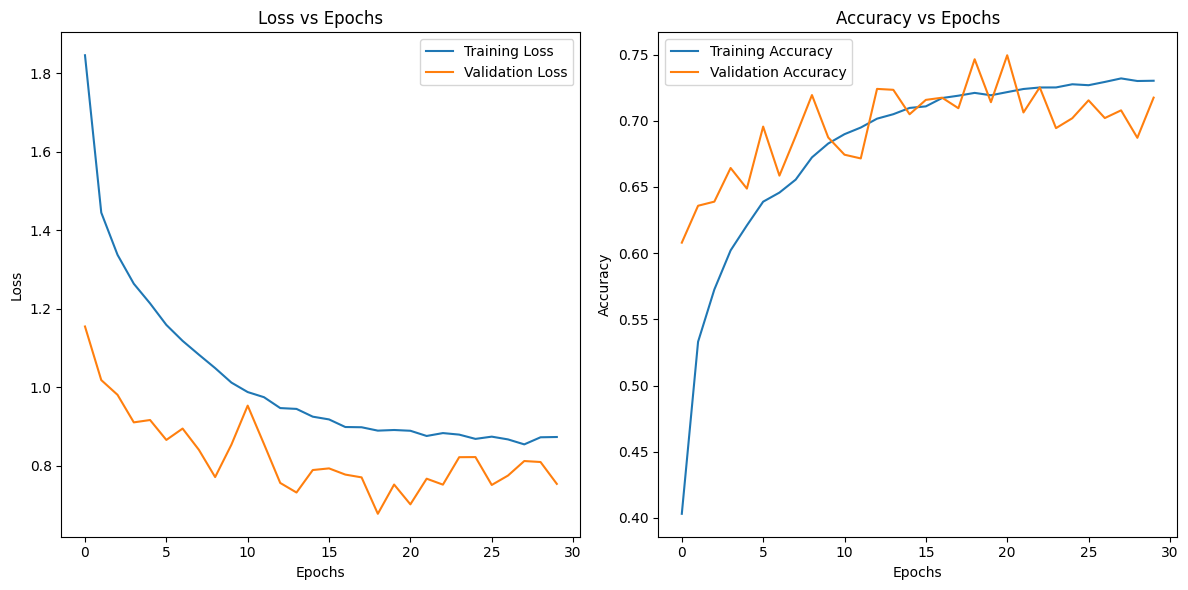

In [30]:
# Plot loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate the model on the test data

In [31]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
test_error = 1 - test_accuracy

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Error: {test_error * 100:.2f}%")

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7134 - loss: 0.7610
Test Accuracy: 71.73%
Test Error: 28.27%


## Evaluate the model on the validation data

In [32]:
validation_loss, validation_accuracy = model.evaluate(validation_images, validation_labels_encoded)
validation_error = 1 - validation_accuracy

print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation Error: {validation_error * 100:.2f}%")

645/645 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7178 - loss: 0.7493
Validation Accuracy: 71.75%
Validation Error: 28.25%


## Plot Model Performance

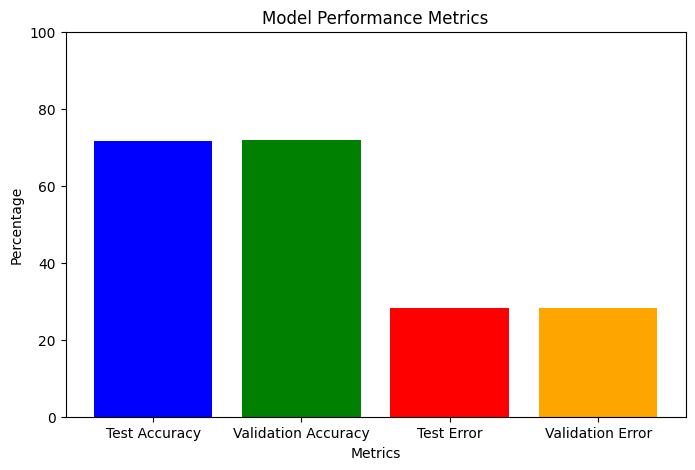

In [33]:
metrics = ['Test Accuracy', 'Validation Accuracy', 'Test Error', 'Validation Error']
values = [test_accuracy * 100, validation_accuracy * 100, test_error * 100, validation_error * 100]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Percentage')
plt.title('Model Performance Metrics')
plt.ylim(0, 100)
plt.show()

## Predict labels for the test images

In [34]:
def predict_on_test_data(test_images):

    # Predict labels for the test images
    predictions = model.predict(test_images)

    # Get the predicted class labels
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    return predicted_labels

# Predict labels for the test data
predicted_test_labels = predict_on_test_data(test_images)

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## Plot confusion matrix

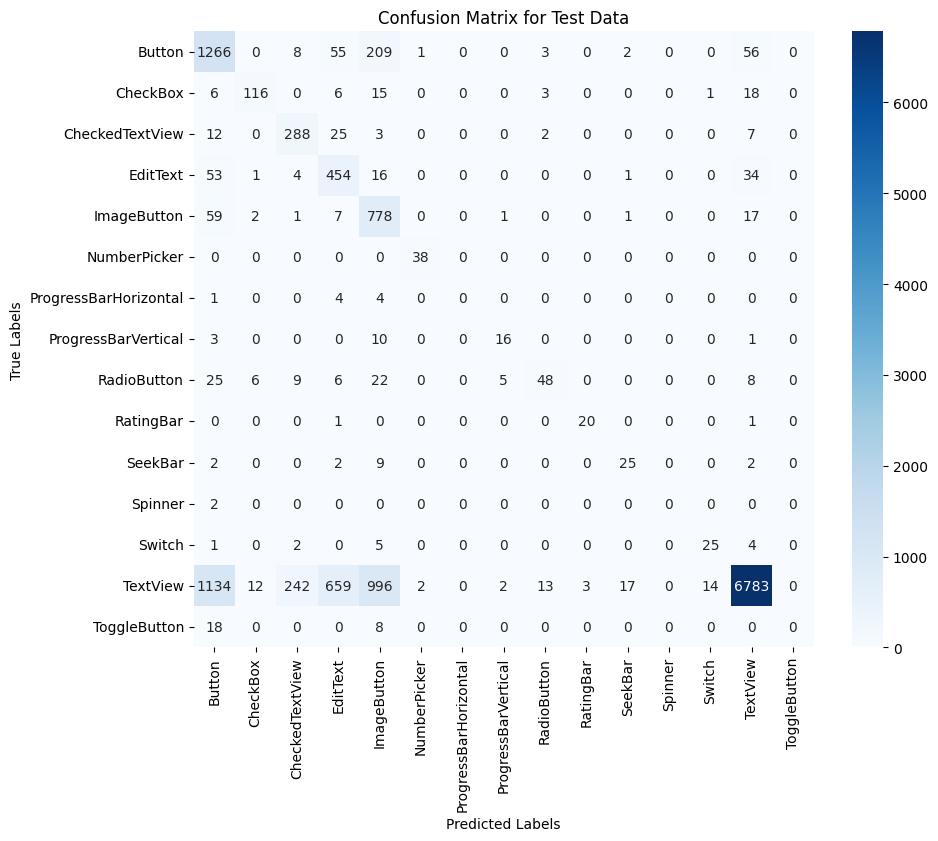

In [35]:
predicted_test_labels_str = label_encoder.transform(predicted_test_labels)

# Generate confusion matrix for the test data
cm = confusion_matrix(test_labels_encoded, predicted_test_labels_str)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Adding labels and title to the plot
plt.title("Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()


## Calculate accuracy, precision, recall and f1 score

In [36]:
# Calculate accuracy
accuracy = accuracy_score(test_labels_encoded, predicted_test_labels_str)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision with zero_division handling
precision = precision_score(test_labels_encoded, predicted_test_labels_str, average='weighted', zero_division=0)
print(f"Precision: {precision:.4f}")

# Calculate recall with zero_division handling
recall = recall_score(test_labels_encoded, predicted_test_labels_str, average='weighted', zero_division=0)
print(f"Recall: {recall:.4f}")

# Optionally, calculate F1-score with zero_division handling
f1 = f1_score(test_labels_encoded, predicted_test_labels_str, average='weighted', zero_division=0)
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.7173
Precision: 0.8376
Recall: 0.7173
F1 Score: 0.7433


## Classify UI Components in a New Image

In [37]:
def classify_ui_components(image_path, model, encoder):
    processed_image, _, _, detected_components = process_ui_image(image_path)

    if processed_image is None:
        return None, None, None

    # Prepare images for classification
    component_images = []
    for (x, y, w, h) in detected_components:
        component_img = processed_image[y:y+h, x:x+w]
        component_img_resized = cv2.resize(component_img, (32, 32))  # Resize for CNN
        component_images.append(component_img_resized)

    if len(component_images) == 0:
        print("No components detected.")
        return [], detected_components, processed_image

    # Convert list of component images to a numpy array
    component_images_array = np.array(component_images, dtype=np.float32) / 255.0  # Normalize

    # Predict labels for each component
    predictions = model.predict(component_images_array)
    predicted_labels = encoder.inverse_transform(np.argmax(predictions, axis=1))

    return predicted_labels, detected_components, processed_image


## Display Detected UI Components with Bounding Boxes

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 489ms/step


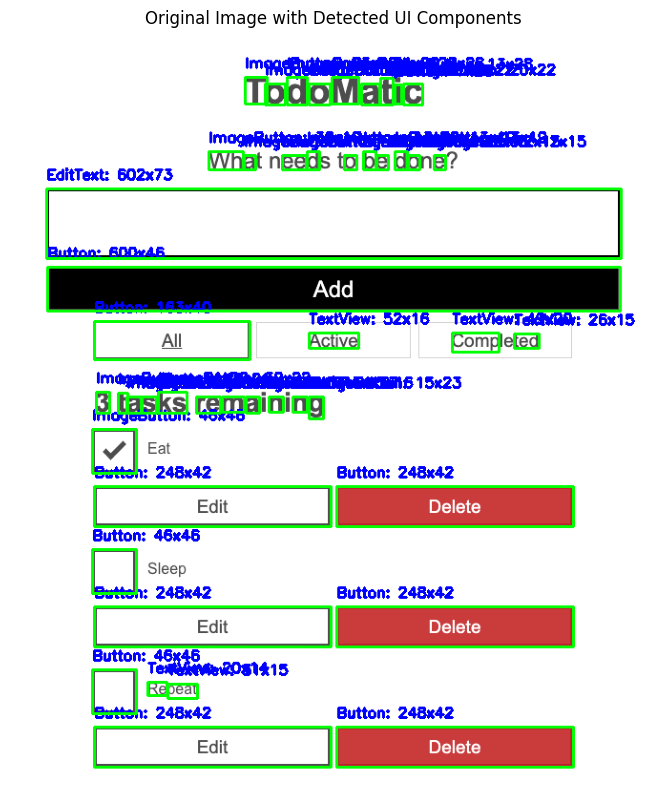

In [38]:
image_path = '/kaggle/input/test-images/images/todo.png'
predicted_labels, detected_components, processed_image = classify_ui_components(image_path, model, label_encoder)
# Display the Original Image with Bounding Boxes, Labels, and Dimensions
if processed_image is not None:
    plt.figure(figsize=(10, 10))
    # Convert to RGB for displaying in matplotlib
    image_with_boxes = processed_image.copy()

    # Create a list to hold detected components data
    detected_components_data = []

    # Draw bounding boxes, labels, and dimensions
    for (x, y, w, h), label in zip(detected_components, predicted_labels):
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
        label_text = f"{label}: {w}x{h}"  # Label text with dimensions
        cv2.putText(image_with_boxes, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Draw label above box in red

        # Append component data to the list
        component_data = {
            "label": label,
            "bounding_box": {
                "x": x,
                "y": y,
                "width": w,
                "height": h
            }
        }
        detected_components_data.append(component_data)

    # Display the image with bounding boxes
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.title("Original Image with Detected UI Components")
    plt.axis('off')
    plt.show()
else:
    print("No processed image to display.")

## Convert Detected Components Data to JSON

In [39]:
def convert_detections_to_json(predicted_labels, detected_components):
    """
    Convert detected UI components and their labels to JSON format.
    
    Args:
        predicted_labels: List of predicted component labels
        detected_components: List of tuples containing (x, y, width, height)
    
    Returns:
        str: JSON string containing component information
    """
    components_data = []
    
    for label, (x, y, w, h) in zip(predicted_labels, detected_components):
        # Convert numpy values to native Python types
        component = {
            "label": str(label),  # Convert label to string
            "bounding_box": {
                "x": int(x.item() if isinstance(x, np.integer) else x),
                "y": int(y.item() if isinstance(y, np.integer) else y),
                "width": int(w.item() if isinstance(w, np.integer) else w),
                "height": int(h.item() if isinstance(h, np.integer) else h)
            }
        }
        components_data.append(component)
    
    # Convert to JSON string with proper formatting
    json_output = json.dumps(components_data, indent=2)
    return json_output

# Generate JSON
image_path = '/kaggle/input/test-images/images/todo.png'
predicted_labels, detected_components, processed_image = classify_ui_components(image_path, model, label_encoder)

if processed_image is not None:
    # Generate JSON
    json_output = convert_detections_to_json(predicted_labels, detected_components)
    print("Generated JSON:")
    print(json_output)
else:
    print("No processed image to generate JSON.")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Generated JSON:
[
  {
    "label": "Button",
    "bounding_box": {
      "x": 342,
      "y": 728,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 88,
      "y": 728,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "TextView",
    "bounding_box": {
      "x": 165,
      "y": 683,
      "width": 31,
      "height": 15
    }
  },
  {
    "label": "TextView",
    "bounding_box": {
      "x": 144,
      "y": 681,
      "width": 20,
      "height": 14
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 86,
      "y": 668,
      "width": 46,
      "height": 46
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 342,
      "y": 602,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "Button",
    "bounding_box": {
      "x": 88,
      "y": 602,
      "width": 248,
      "height": 42
    }
  },
  {
    "label": "Button",
  

## Generate Kotlin Code for Detected Components

In [40]:
import json

def generate_kotlin_code(json_output):
    # Convert string to list of dictionaries if it's a string
    if isinstance(json_output, str):
        components = json.loads(json_output)  # Parse the JSON string directly
    else:
        components = json_output

    kotlin_code = """
import android.os.Bundle
import androidx.appcompat.app.AppCompatActivity
import android.widget.*
import android.view.ViewGroup.LayoutParams
import android.view.ViewGroup

class MainActivity : AppCompatActivity() {
    override fun onCreate(savedInstanceState: Bundle?) {
        super.onCreate(savedInstanceState)
        
        // Create ConstraintLayout as root view
        val rootLayout = ConstraintLayout(this).apply {
            layoutParams = ViewGroup.LayoutParams(
                ViewGroup.LayoutParams.MATCH_PARENT,
                ViewGroup.LayoutParams.MATCH_PARENT
            )
        }
        
        // Initialize components
"""

    # Generate component creation code
    for idx, component in enumerate(components):
        label = component['label']
        box = component['bounding_box']
        
        # Generate unique ID for each component
        component_id = f"component{idx}"
        
        # Create component initialization code
        kotlin_code += f"""
        val {component_id} = {label}(this).apply {{
            id = View.generateViewId()
            layoutParams = ConstraintLayout.LayoutParams(
                {box['width']}, {box['height']}
            ).apply {{
                // Set margins based on x,y coordinates
                leftMargin = {box['x']}
                topMargin = {box['y']}
            }}
            
            // Set default properties based on component type
            when (this) {{
                is ImageView -> {{
                    scaleType = ImageView.ScaleType.FIT_CENTER
                    setBackgroundColor(Color.LTGRAY) // Placeholder background
                }}
                is TextView -> {{
                    text = "Sample Text"
                }}
                is Button -> {{
                    text = "Click Me"
                }}
                is EditText -> {{
                    hint = "Enter text"
                }}
            }}
        }}
        rootLayout.addView({component_id})
"""

    # Close the class
    kotlin_code += """
        // Set the root layout as content view
        setContentView(rootLayout)
    }
}
"""

    return kotlin_code


# Assuming json_output is a valid JSON string, like:
json_output = '[{"label": "TextView", "bounding_box": {"x": 50, "y": 100, "width": 200, "height": 50}}, {"label": "Button", "bounding_box": {"x": 50, "y": 200, "width": 200, "height": 50}}]'

# Generate the Kotlin code
kotlin_code = generate_kotlin_code(json_output)

# Save to file
with open('GeneratedLayout.kt', 'w') as f:
    f.write(kotlin_code)

print("Kotlin code has been generated and saved to GeneratedLayout.kt")


Kotlin code has been generated and saved to GeneratedLayout.kt
